# Online Learning and Prediction of Time-series with OR-ELM

Online-Recurrent-Extreme-Learning-Machine (OR-ELM) for time-series prediction, implemented in python.


## Requirements
* Python 2.7
* Numpy
* Matplotlib
* pandas
* Expsuite (included in this repository)

## Dataset
* NYC taxi passenger count
 * Prediction of the New York City taxi passenger data. left.
Example portion of taxi passenger data (aggregated at 30 min
intervals).
  * public data stream provided by the [New
York City Transportation Authority](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml )
  * preprocessed (aggregated at 30 min intervals) by Cui, Yuwei, et al. in ["A comparative study of HTM and other neural network models for online sequence learning with streaming data." Neural Networks (IJCNN), 2016 International Joint Conference on. IEEE, 2016.](http://ieeexplore.ieee.org/abstract/document/7727380/)
  , [code](https://github.com/numenta/htmresearch/tree/master/projects/sequence_prediction)

![example](https://raw.githubusercontent.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine/master/fig/NYCexample.png)



## Setup


### Clone OR-ELM Github repository

In [ ]:
#!git clone https://github.com/chickenbestlover/Online-Recurrent-Extreme-Learning-Machine.git

In [ ]:
# import os
# print(os.getcwd())
# !ls
# os.chdir('Online-Recurrent-Extreme-Learning-Machine')
# !ls

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [40]:
import csv
#from optparse import OptionParser
from matplotlib import pyplot as plt
import numpy as np
from scipy import random
import pandas as pd
from numpy.linalg import pinv
from numpy.linalg import inv
random.seed(0)

### Set hyper-parameters for the dataset

In [55]:
numLags = 300
predictionStep = 20




In [56]:
filePath="/content/drive/My Drive/praying pals/ExtremeLearningMachine/Online-Recurrent-Extreme-Learning-Machine/data/MackeyGlass.csv"

### Read dataset

In [57]:
dataSet = 'nyc_taxi'
df = pd.read_csv(filePath, header=0, skiprows=[1,2], names=['price'])
df.head(5)

,price
0,0.764913
1,0.829415
2,0.885580
3,0.931807
4,0.967596


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
price    3000 non-null float64
dtypes: float64(1)
memory usage: 23.5 KB


In [59]:
df.isnull().sum()

price    0
dtype: int64

In [60]:
  # standardize data by subtracting mean and dividing by std
  meanSeq = np.mean(df['price'])
  stdSeq = np.std(df['price'])
  df['price'] = (df['price'] - meanSeq)/stdSeq

In [61]:
df.head()

,price
0,-0.732992
1,-0.447219
2,-0.198388
3,0.006420
4,0.164981


### Prepare input-target pairs 

In [62]:
def getTimeEmbeddedMatrix(sequence, numLags=100, predictionStep=1):
  print("generate time embedded matrix")
  inDim = numLags
  X = np.zeros(shape=(len(sequence), inDim))
  T = np.zeros(shape=(len(sequence), 1))
  for i in xrange(numLags-1, len(sequence)-predictionStep):
    X[i, :] = np.array(sequence['price'][(i-numLags+1):(i+1)])
    T[i, :] = sequence['price'][i+predictionStep]
  print('input shape: ',X.shape)
  print('target shape: ',T.shape)
  return (X, T)

(X, T) = getTimeEmbeddedMatrix(df, numLags, predictionStep)

generate time embedded matrix
('input shape: ', (3000, 300))
('target shape: ', (3000, 1))


In [63]:
print(X.shape, T.shape)

((3000, 300), (3000, 1))


### Set model hyper-parameters

In [64]:
nDimInput = 300
nDimOutput = 1
numNeurons = 25
algorithm = 'OSELM'
LN=True
InWeightFF=1.0
OutWeightFF=0.92
HiddenWeightFF=1.0
AE=True
lamb=0.0001

print('----------Network Configuration-------------------')
print('Algotirhm = '+algorithm)
print('#input neuron = '+str(nDimInput))
print('#output neuron = '+str(nDimOutput))
print('#hidden neuron = '+str(numNeurons))
print('Layer normalization = ' + str(LN))
print('Auto-encoding = '+str(AE))
print('input weight forgetting factor = '+str(InWeightFF))
print('output weight forgetting factor = ' + str(OutWeightFF))
print('hidden weight forgetting factor = ' + str(HiddenWeightFF))
print('---------------------------------------------------')

----------Network Configuration-------------------
Algotirhm = OSELM
#input neuron = 300
#output neuron = 1
#hidden neuron = 25
Layer normalization = True
Auto-encoding = True
input weight forgetting factor = 1.0
output weight forgetting factor = 0.92
hidden weight forgetting factor = 1.0
---------------------------------------------------


# Online Sequential Extreme Learning Machine (OS-ELM)

## Base operation: linear layer with nonlinear activation using NumPy

In [65]:
weights = np.random.random((20,300))
print('weights:',weights.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,300))
print('input features:', features.shape)

def linear(features,weights,bias):
   return np.dot(features, np.transpose(weights)) + bias

hidden = linear(features,weights,bias)
print('hidden (before nonlinear activation):', hidden.shape)

def sigmoidActFunc(features):
  return 1.0 / (1.0 + np.exp(-features))

hidden = sigmoidActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)

def reluActFunc(features):
  return np.maximum(0,features)
hidden = reluActFunc(hidden)
print('hidden (after nonlinear activateion):', hidden.shape)


('weights:', (20, 300))
('bias:', (1, 20))
('input features:', (1, 300))
('hidden (before nonlinear activation):', (1, 20))
('hidden (after nonlinear activateion):', (1, 20))
('hidden (after nonlinear activateion):', (1, 20))


## OSELM implementation

In [66]:
class OSELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, forgettingFactor=0.999):
    self.name = 'OSELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights = None
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None
    # auxiliary matrix used for sequential learning
    self.M = None

    self.forgettingFactor = forgettingFactor

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """
    V = linear(features, self.inputWeights,self.bias)
    #H = sigmoidActFunc(V)
    H = reluActFunc(V)
    return H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    """
    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    # auxiliary matrix used for sequential learning
    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    # hidden to output layer connection
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])



  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)


    self.M = (1/self.forgettingFactor) * self.M - np.dot((1/self.forgettingFactor) * self.M,
                                     np.dot(Ht, np.dot(
                                       pinv(np.eye(numSamples) + np.dot(H, np.dot((1/self.forgettingFactor) * self.M, Ht))),
                                       np.dot(H, (1/self.forgettingFactor) * self.M))))
    self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction



In [67]:
net = OSELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons,forgettingFactor=OutWeightFF)
net.initializePhase(lamb=0.0001)

### Online learning and prediction of OS-ELM

In [68]:
  predictions= []
  target= []

  for i in xrange(numLags, len(df)-predictionStep-1):
    net.train(X[[i], :], T[[i], :])
    Y = net.predict(X[[i+1], :])

    predictions.append(Y[0][0])
    target.append(T[i][0])

    print "{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1])

  300th timeStep -  target:   0.9639   |    prediction:   1.0059 
  301th timeStep -  target:   0.8477   |    prediction:   0.7279 
  302th timeStep -  target:   0.7223   |    prediction:   0.6283 
  303th timeStep -  target:   0.6010   |    prediction:   0.4796 
  304th timeStep -  target:   0.4929   |    prediction:   0.4060 
  305th timeStep -  target:   0.4027   |    prediction:   0.3610 
  306th timeStep -  target:   0.3310   |    prediction:   0.2841 
  307th timeStep -  target:   0.2733   |    prediction:   0.2272 
  308th timeStep -  target:   0.2207   |    prediction:   0.1758 
  309th timeStep -  target:   0.1601   |    prediction:   0.0894 
  310th timeStep -  target:   0.0776   |    prediction:  -0.0309 
  311th timeStep -  target:  -0.0375   |    prediction:  -0.1840 
  312th timeStep -  target:  -0.1872   |    prediction:  -0.3660 
  313th timeStep -  target:  -0.3627   |    prediction:  -0.5498 
  314th timeStep -  target:  -0.5480   |    prediction:  -0.7244 
  315th ti

  ### Evaluation: Calculate total Normalized Root Mean Square Error (NRMSE)

In [69]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  
def computeSquareDeviation(predictions, truth):
  squareDeviation = np.square(predictions-truth)
  return squareDeviation

# Calculate NRMSE from skip_eval to the end
skip_eval=100
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))


NRMSE 0.166109385294


### Plot predictions and target values

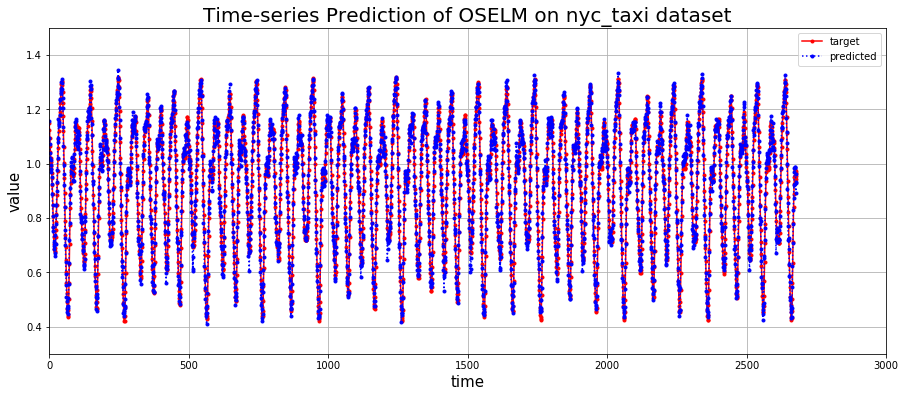

Prediction plot is saved to./predictionPlot.png


In [70]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
  predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
  plt.xlim([0,3000])
  plt.ylim([0.3, 1.5])
  plt.ylabel('value',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction plot is saved to'+plot_path)

# Online Recurrent Extreme Learning Machine (OR-ELM)

## Base operation: recurrent layer with nonlinear activation using NumPy

In [ ]:
def linear_recurrent(features, inputW,hiddenW,hiddenA, bias):
  V = np.dot(features, np.transpose(inputW)) + np.dot(hiddenA,hiddenW) + bias
  return V

def layerNormalization(H, scaleFactor=1, biasFactor=0):

  H_normalized = (H-H.mean())/(np.sqrt(H.var() + 0.000001))
  H_normalized = scaleFactor*H_normalized+biasFactor

  return H_normalized

inputW = np.random.random((20,300))
print('input_weights:',inputW.shape)

hiddenW = np.random.random((20,20))
print('hidden_weights:',hiddenW.shape)

bias = np.random.random((1,20)) * 2 -1
print('bias:', bias.shape)

features = np.random.random((1,300))
print('input features:', features.shape)

hiddenA = np.random.random((1,20))

hidden = linear_recurrent(features,inputW,hiddenW,hiddenA,bias)
print('hidden:',hidden.shape)

hidden = layerNormalization(hidden)
print('hidden:',hidden.shape)


('input_weights:', (20, 300))
('hidden_weights:', (20, 20))
('bias:', (1, 20))
('input features:', (1, 300))
('hidden:', (1, 20))
('hidden:', (1, 20))


## ORELM implementation

In [72]:
class ORELM(object):
  def __init__(self, inputs, outputs, numHiddenNeurons, LN=True, AE=True,
               inputWeightForgettingFactor=1.0,
               outputWeightForgettingFactor=1.0,
               hiddenWeightForgettingFactor=1.0):
    self.name = 'ORELM'
    self.inputs = inputs
    self.outputs = outputs
    self.numHiddenNeurons = numHiddenNeurons

    # input to hidden weights
    self.inputWeights  = None
    # hidden layer to hidden layer wieghts
    self.hiddenWeights = None
    # initial hidden layer activation
    self.initial_H = None
    self.H = self.initial_H
    self.LN = LN
    self.AE = AE
    # bias of hidden units
    self.bias = None
    # hidden to output layer connection
    self.beta = None

    # auxiliary matrix used for sequential learning
    self.M = None
    
    self.forgettingFactor = outputWeightForgettingFactor


    if self.AE:
      self.inputAE = OSELM(inputs = inputs,
                            outputs = inputs,
                            numHiddenNeurons = numHiddenNeurons,
                            forgettingFactor=inputWeightForgettingFactor,
                            )

      self.hiddenAE = OSELM(inputs = numHiddenNeurons,
                             outputs = numHiddenNeurons,
                             numHiddenNeurons = numHiddenNeurons,
                             forgettingFactor=hiddenWeightForgettingFactor,
                             )


  def __calculateInputWeightsUsingAE(self, features):
    self.inputAE.train(features,features)
    return self.inputAE.beta

  def __calculateHiddenWeightsUsingAE(self, features):
    self.hiddenAE.train(features,features)
    return self.hiddenAE.beta

  def calculateHiddenLayerActivation(self, features):
    """
    Calculate activation level of the hidden layer
    :param features feature matrix with dimension (numSamples, numInputs)
    :return: activation level (numSamples, numHiddenNeurons)
    """


    if self.AE:
      self.inputWeights = self.__calculateInputWeightsUsingAE(features)

      self.hiddenWeights = self.__calculateHiddenWeightsUsingAE(self.H)

    V = linear_recurrent(features=features,
                         inputW=self.inputWeights,
                         hiddenW=self.hiddenWeights,
                         hiddenA=self.H,
                         bias= self.bias)
    if self.LN:
      V = layerNormalization(V)
    self.H = sigmoidActFunc(V)
    #self.H = reluActFunc(V)

    return self.H


  def initializePhase(self, lamb=0.0001):
    """
    Step 1: Initialization phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    self.initial_H = np.random.random((1, self.numHiddenNeurons)) * 2 -1
    self.H = self.initial_H

    self.M = inv(lamb*np.eye(self.numHiddenNeurons))
    self.beta = np.zeros([self.numHiddenNeurons,self.outputs])

    # randomly initialize the input->hidden connections
    self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
    self.inputWeights = self.inputWeights * 2 - 1
    self.bias = np.random.random((1, self.numHiddenNeurons)) * 2 - 1
    
    if self.AE:
      self.inputAE.initializePhase(lamb=0.00001)
      self.hiddenAE.initializePhase(lamb=0.00001)
    else:
      # randomly initialize the input->hidden connections
      self.inputWeights = np.random.random((self.numHiddenNeurons, self.inputs))
      self.inputWeights = self.inputWeights * 2 - 1

      # hidden layer to hidden layer wieghts
      self.hiddenWeights = np.random.random((self.numHiddenNeurons, self.numHiddenNeurons))
      self.hiddenWeights = self.hiddenWeights * 2 - 1


  def reset(self):
    self.H = self.initial_H

  def train(self, features, targets):
    """
    Step 2: Sequential learning phase
    :param features feature matrix with dimension (numSamples, numInputs)
    :param targets target matrix with dimension (numSamples, numOutputs)
    """
    (numSamples, numOutputs) = targets.shape
    assert features.shape[0] == targets.shape[0]

    H = self.calculateHiddenLayerActivation(features)
    Ht = np.transpose(H)
    try:
      scale = 1/(self.forgettingFactor)
      self.M = scale*self.M - np.dot(scale*self.M,
                       np.dot(Ht, np.dot(
          pinv(np.eye(numSamples) + np.dot(H, np.dot(scale*self.M, Ht))),
          np.dot(H, scale*self.M))))

      self.beta = self.beta + np.dot(self.M, np.dot(Ht, targets - np.dot(H, self.beta)))


    except np.linalg.linalg.LinAlgError:
      print "SVD not converge, ignore the current training cycle"
    # else:
    #   raise RuntimeError

  def predict(self, features):
    """
    Make prediction with feature matrix
    :param features: feature matrix with dimension (numSamples, numInputs)
    :return: predictions with dimension (numSamples, numOutputs)
    """
    H = self.calculateHiddenLayerActivation(features)
    prediction = np.dot(H, self.beta)
    return prediction

In [73]:
net = ORELM(inputs=nDimInput,outputs=nDimOutput, numHiddenNeurons=numNeurons, outputWeightForgettingFactor=0.92)
net.initializePhase(lamb=0.0001)

### Online learning and prediction of OR-ELM

In [74]:
  predictions= []
  target= []

  for i in xrange(numLags, len(df)-predictionStep-1):
    net.train(X[[i], :], T[[i], :])
    Y = net.predict(X[[i+1], :])

    predictions.append(Y[0][0])
    target.append(T[i][0])

    print "{:5}th timeStep -  target: {:8.4f}   |    prediction: {:8.4f} ".format(i, target[-1], predictions[-1])


  300th timeStep -  target:   0.9639   |    prediction:   0.9595 
  301th timeStep -  target:   0.8477   |    prediction:   0.7946 
  302th timeStep -  target:   0.7223   |    prediction:   0.7142 
  303th timeStep -  target:   0.6010   |    prediction:   0.4557 
  304th timeStep -  target:   0.4929   |    prediction:   0.3796 
  305th timeStep -  target:   0.4027   |    prediction:   0.3839 
  306th timeStep -  target:   0.3310   |    prediction:   0.2663 
  307th timeStep -  target:   0.2733   |    prediction:   0.2660 
  308th timeStep -  target:   0.2207   |    prediction:   0.1482 
  309th timeStep -  target:   0.1601   |    prediction:   0.1224 
  310th timeStep -  target:   0.0776   |    prediction:   0.1970 
  311th timeStep -  target:  -0.0375   |    prediction:   0.7564 
  312th timeStep -  target:  -0.1872   |    prediction:   0.0017 
  313th timeStep -  target:  -0.3627   |    prediction:  -0.5690 
  314th timeStep -  target:  -0.5480   |    prediction:  -0.4686 
  315th ti

### Evaluation: Calculate total Normalized Root Mean Square Error (NRMSE)

In [75]:
# Reconstruct original value
predictions = np.array(predictions)
target = np.array(target)
predictions = predictions * stdSeq + meanSeq
target = target * stdSeq + meanSeq
  

# Calculate NRMSE from skip_eval to the end
skip_eval=300
squareDeviation = computeSquareDeviation(predictions, target)
squareDeviation[:skip_eval] = None
nrmse = np.sqrt(np.nanmean(squareDeviation)) / np.nanstd(predictions)
print("NRMSE {}".format(nrmse))

NRMSE 0.223962450826


### Plot predictions and target values

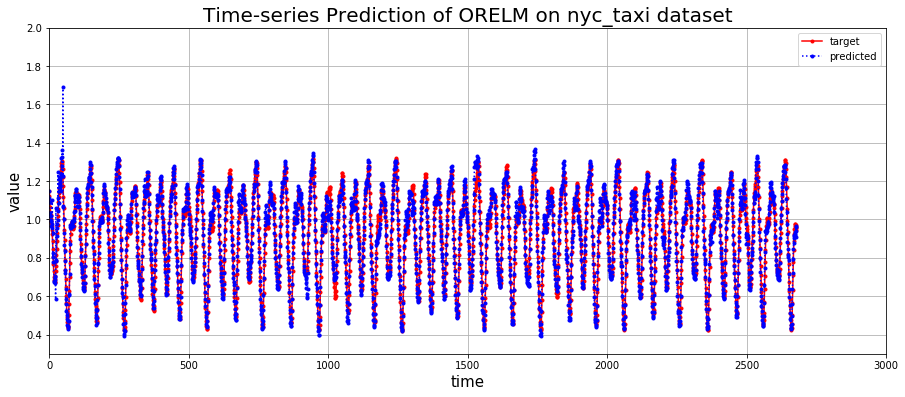

Prediction plot is saved to./predictionPlot.png


In [79]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
  predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
  plt.xlim([0,3000])
  plt.ylim([0.3, 2])
  plt.ylabel('value',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction plot is saved to'+plot_path)

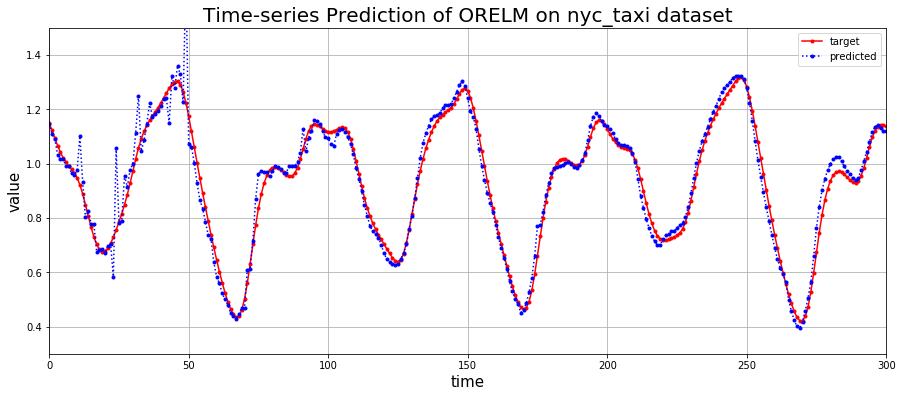

Prediction plot is saved to./predictionPlot.png


In [77]:
  algorithm= net.name
  plt.figure(figsize=(15,6))
  targetPlot,=plt.plot(target,label='target',color='red',marker='.',linestyle='-')
  predictedPlot,=plt.plot(predictions,label='predicted',color='blue',marker='.',linestyle=':')
  plt.xlim([0,300])
  plt.ylim([0.3, 1.5])
  plt.ylabel('value',fontsize=15)
  plt.xlabel('time',fontsize=15)
  plt.ion()
  plt.grid()
  plt.legend(handles=[targetPlot, predictedPlot])
  plt.title('Time-series Prediction of '+algorithm+' on '+dataSet+' dataset',fontsize=20,fontweight=40)
  plot_path = './predictionPlot.png'
  plt.savefig(plot_path,plot_pathbbox_inches='tight')
  plt.draw()
  plt.show()
  plt.pause(0)
  print('Prediction plot is saved to'+plot_path)